In [1]:
# %pip install numpy
# %pip install ipywidgets
# %pip install torch
# %pip install torchvision
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install kagglehub

In [2]:
import os, random
import numpy as np
from PIL import Image
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, random_split
from torchvision import transforms, models
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Download latest version https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data

## Data preprocessing

In [3]:
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
dataset_path_train = f"{path}/Training"
dataset_path_test  = f"{path}/Testing"
img_size = (224, 224)
class_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
samples_per_class = 2000

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

label_encoder = LabelEncoder()

def load_images_from_folder(folder, label, transform):
    data, labels = [], []
    for img_name in os.listdir(folder):
        try:
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"[Warning] Error loading {img_path}: {e}")
    return data, labels

def load_dataset(dataset_path, transform, limit_per_class=None):
    X_all, y_all = [], []
    for class_name in class_names:
        folder = os.path.join(dataset_path, class_name)
        X_class, y_class = load_images_from_folder(folder, class_name, transform)
        if limit_per_class and len(X_class) > 0:
            X_class, y_class = resample(X_class, y_class, replace=True, n_samples=limit_per_class, random_state=42)
        X_all.extend(X_class)
        y_all.extend(y_class)
    label_encoder.fit(y_all)
    y_encoded = label_encoder.transform(y_all)
    return torch.stack(X_all), torch.tensor(y_encoded)

X_train, y_train = load_dataset(dataset_path_train, train_transform, samples_per_class)
X_test, y_test = load_dataset(dataset_path_test, test_transform, samples_per_class // 2)

full_dataset = TensorDataset(X_train, y_train)

dataset_len = len(full_dataset)
train_size = int(0.9 * dataset_len)
val_size = dataset_len - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

y_train_subset = y_train[train_subset.indices]
num_classes = len(class_names)
counts = np.bincount(y_train_subset.numpy(), minlength=num_classes)
counts[counts == 0] = 1
class_weights = torch.tensor((counts.sum() / (num_classes * counts)).astype(np.float32))  # inversely proportional

sample_weights = class_weights[y_train_subset].double()
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False, pin_memory=True)

## Hybrid model

In [ ]:
qdevice = qml.device("default.qubit", wires=6)

@qml.qnode(qdevice, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(6):
        qml.RY(inputs[i % len(inputs)], wires=i)
    qml.templates.BasicEntanglerLayers(weights, wires=range(6))
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

q_shapes = {"weights": (4, 6)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, q_shapes).to(device)

class QuantumResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            self.base_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        except Exception:
            self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 6)
        self.quantum = quantum_layer
        self.fc2 = nn.Linear(4, 4)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = torch.stack([self.quantum(xi) for xi in x], dim=0)
        x = self.fc2(x) 
        return x

## Train

In [5]:
def train_model(model, train_loader, val_loader, epochs=5, patience=3, lr=3e-4, wd=1e-5, class_weights=None):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device) if class_weights is not None else None,
                                    label_smoothing=0.1)

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y_batch.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
            total += y_batch.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct/total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits = model(X_val)
                loss = criterion(logits, y_val)
                val_loss += loss.item() * y_val.size(0)
                pred = logits.argmax(dim=1)
                val_correct += (pred == y_val).sum().item()
                val_total += y_val.size(0)

        val_loss /= max(1, val_total)
        val_acc = val_correct / max(1, val_total)
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

model = QuantumResNetClassifier()
history = train_model(model, train_loader, val_loader, epochs=5, patience=3, class_weights=class_weights)

Epoch 1, Val Loss: 1.2613, Val Acc: 0.4850


Epoch 2, Val Loss: 1.1898, Val Acc: 0.4888


Epoch 3, Val Loss: 1.1061, Val Acc: 0.5012


Epoch 4, Val Loss: 0.9966, Val Acc: 0.7362


Epoch 5, Val Loss: 0.8802, Val Acc: 0.9862


## Evaluation

Accuracy: 98.62%
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.99      0.99       202
meningioma_tumor       0.99      0.96      0.98       192
        no_tumor       1.00      0.99      0.99       194
 pituitary_tumor       0.97      1.00      0.99       212

        accuracy                           0.99       800
       macro avg       0.99      0.99      0.99       800
    weighted avg       0.99      0.99      0.99       800



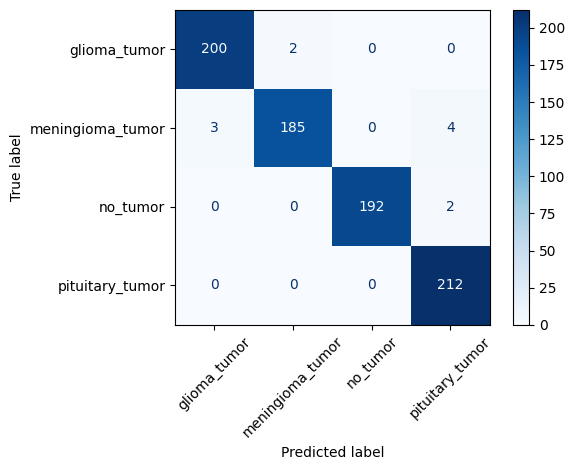

In [10]:
def evaluate(model, loader, class_names):
    model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logp = model(xb)
            preds = logp.argmax(dim=1).cpu().numpy()
            yh.extend(preds); ys.extend(yb.numpy())
    print(f"Accuracy: {metrics.accuracy_score(ys, yh)*100:.2f}%")
    print(metrics.classification_report(ys, yh, target_names=class_names))
    metrics.ConfusionMatrixDisplay.from_predictions(ys, yh, display_labels=class_names, xticks_rotation=45, cmap="Blues")
    plt.tight_layout(); plt.show()

evaluate(model, val_loader, class_names)